In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

pm.__version__

'3.6'

# PYMC3

# Two timelines:

In [11]:
x = np.arange(1989,2018,1).reshape(-1,1)

X = np.concatenate([x,x,x])
#X = np.concatenate([x,x])

y0 = [0,0,0,0,20,50,350,300,320,140,120,200,100,50,10,3,2,0,0,0,2,0,0,0,0,0,0,0,0]
y1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,0,35,30,80,100,90,105]
y2 = [135,130,80,100,90,70,10,0,0,0,0,0,10,30,4,0,0,5,0,0,0,0,0,4,20,45,80,160,190]

#y = np.array(y0 + y1)
y = np.array(y0 + y1 + y2)

index = np.array([0]*len(y0)+[1]*len(y1)+[2]*len(y2))
#index = np.array([0]*len(y0)+[1]*len(y1))

# new values from x=1989 to x=2020
X_new = np.linspace(1989, 2050, 100)[:,None]

# Just for plotting
pred_years =  np.arange(2017, 2051, 1)


Men du kunne også bare lade konflicterne løbe efter hinanden i en lang x... og estimere dine hyper parametere derfra?

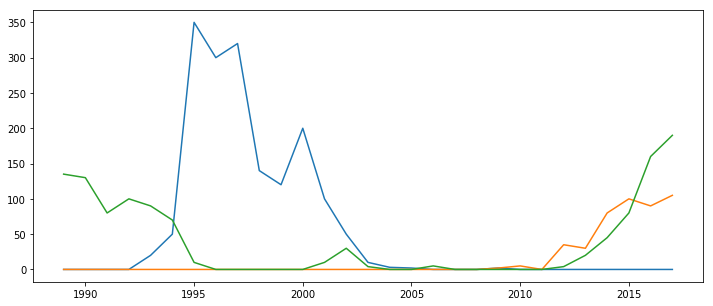

In [12]:
fig = plt.figure(figsize=(12,5))

for i in set(index):
    plt.plot(X[index == i],y[index==i])
    
plt.show()

##  plot function:


In [13]:
def index_plot():
    #plot the results
    fig = plt.figure(figsize=(12,5))
    ax = fig.gca()


    for i in set(index):
        func_id = 'f_pred' + str(i)
        y_id = 'y_pred' + str(i)

        palette = sns.cubehelix_palette(8, start=i, rot=0,  light=0.8, dark=0.2, as_cmap = True)

        plot_gp_dist(ax, pred_samples[func_id], X_new, palette = palette, fill_alpha=0.1, samples_alpha=0.1)
        plot_gp_dist(ax, y_samples[y_id], X_new, plot_samples=False, palette = palette, fill_alpha=0.1, samples_alpha=0.1)
        plt.plot(X[index == i], y[index == i], 'o', ms=6, alpha=0.8) # color seem to be infered..

    # mics: ---------------------------------------------------------------------------------------------------------

    # prediction line
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

    fill_min = pred_years.min()
    fill_max = pred_years.max() + 2
    fill_range = np.arange(fill_min, fill_max, 1)

    plt.fill_between(fill_range,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

    # axis labels and title
    plt.xlabel("Year")
    plt.ylabel('Conflict fatalities')
    plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

    plt.ylim(0,y.max()*1.5)
    plt.xlim(X_new.min(), X_new.max())
    plt.legend(frameon = False, loc = 9)
    #sns.despine()

    #plt.savefig('GP_forcasting_test.png', bbox_inches='tight')

    plt.show()

# Du skal bygger heirarkiet bedre op..

# shrad hyper param  (for-loop for scalable)

In [14]:
with pm.Model() as model:
      
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2, shape = 1)
    η = pm.HalfCauchy("η", beta=5, shape = 1)
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)

    
    gp_list = []

    for i in set(index):
        cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
        gp = pm.gp.Marginal(cov_func=cov)
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == i], y=y[index == i], noise=σ)
        
        gp_list.append(gp)
        
    # here since you do not want to find the map of the conditional distributions
    mp = pm.find_MAP()

    
    f_pred_list = []
    y_pred_list = []
    
    for i in set(index):

        f_pred = gp_list[i].conditional("f_pred" + str(i), X_new)
        f_pred_list.append(f_pred)
        
        y_pred = gp_list[i].conditional("y_pred" + str(i), X_new, pred_noise = True)
        y_pred_list.append(y_pred)
        
    
    pred_samples = pm.sample_posterior_predictive([mp], vars= f_pred_list, samples=100)
    y_samples = pm.sample_posterior_predictive([mp], vars= y_pred_list, samples=100)

        

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -468.87, ||grad|| = 0.75328: 100%|██████████| 16/16 [00:00<00:00, 110.61it/s]  
100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


In [15]:
mp

{'η': array([71.76891881]),
 'η_log__': array([4.2734515]),
 'σ': array([22.31677943]),
 'σ_log__': array([3.10533884]),
 'ℓ': array([1.91656315]),
 'ℓ_log__': array([0.65053355])}

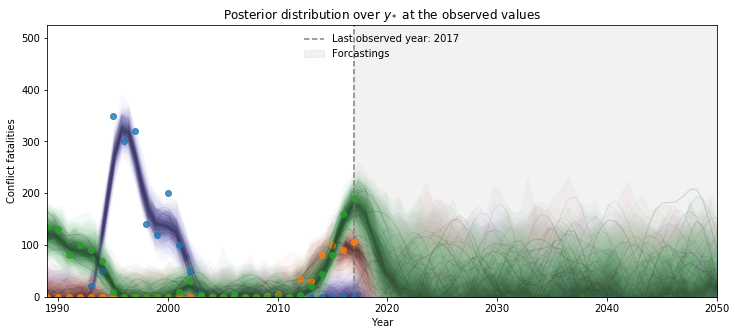

In [16]:
index_plot()

# Hierarchical ℓ  (for-loop for scalable)

In [17]:
with pm.Model() as model:
  

    ℓ_β = pm.HalfNormal('ℓ_β', 2)
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=ℓ_β, shape = len(set(index)))
    η = pm.HalfCauchy("η", beta=5, shape = 1)
    σ = pm.HalfCauchy("σ", beta=5, shape = 1)

    
    gp_list = []

    for i in set(index):
        cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ[i])
        gp = pm.gp.Marginal(cov_func=cov)
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == i], y=y[index == i], noise=σ)
        
        gp_list.append(gp)
        
    # here since you do not want to find the map of the conditional distributions
    mp = pm.find_MAP()

    
    f_pred_list = []
    y_pred_list = []
    
    for i in set(index):

        f_pred = gp_list[i].conditional("f_pred" + str(i), X_new)
        f_pred_list.append(f_pred)
        
        y_pred = gp_list[i].conditional("y_pred" + str(i), X_new, pred_noise = True)
        y_pred_list.append(y_pred)
        
    
    pred_samples = pm.sample_posterior_predictive([mp], vars= f_pred_list, samples=100)
    y_samples = pm.sample_posterior_predictive([mp], vars= y_pred_list, samples=100)

        

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -440.88, ||grad|| = 0.00093467: 100%|██████████| 23/23 [00:00<00:00, 92.52it/s]  
100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


In [18]:
mp

{'η': array([94.35473966]),
 'η_log__': array([4.54706151]),
 'σ': array([9.65608613]),
 'σ_log__': array([2.2675884]),
 'ℓ': array([0.89892268, 6.42320756, 3.86785772]),
 'ℓ_log__': array([-0.10655826,  1.85991761,  1.35270079]),
 'ℓ_β': array(0.52991945),
 'ℓ_β_log__': array(-0.63503027)}

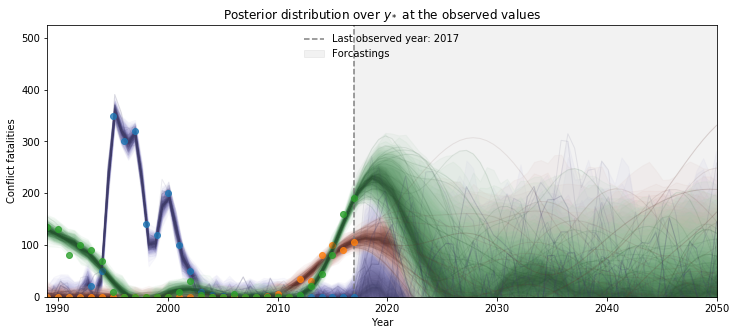

In [19]:
index_plot()

#  Hierarchical ℓ  η, and σ (for-loop for scalable)

In [21]:
with pm.Model() as model:
      
    dim = len(set(index))

    ℓ_β = pm.HalfNormal('ℓ_β', 2)
    η_β = pm.HalfNormal('η_β', 5)
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=ℓ_β, shape = dim)
    η = pm.HalfCauchy("η", beta=η_β, shape = dim)
 
    σ_β = pm.HalfNormal('σ_β', 5)
    σ = pm.HalfCauchy("σ", beta=σ_β, shape = dim)
    
    
    gp_list = []

    for i in set(index):
        cov = η[i] **2 * pm.gp.cov.ExpQuad(1, ℓ[i])
        gp = pm.gp.Marginal(cov_func=cov)
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == i], y=y[index == i], noise=σ[i])
        
        gp_list.append(gp)
        
    # here since you do not want to find the map of the conditional distributions
    mp = pm.find_MAP()

    
    f_pred_list = []
    y_pred_list = []
    
    for i in set(index):

        f_pred = gp_list[i].conditional("f_pred" + str(i), X_new)
        f_pred_list.append(f_pred)
        
        y_pred = gp_list[i].conditional("y_pred" + str(i), X_new, pred_noise = True)
        y_pred_list.append(y_pred)
        
    
    pred_samples = pm.sample_posterior_predictive([mp], vars= f_pred_list, samples=100)
    y_samples = pm.sample_posterior_predictive([mp], vars= y_pred_list, samples=100)

        

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -456.7, ||grad|| = 0.012957: 100%|██████████| 26/26 [00:00<00:00, 87.27it/s]  
100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


In [22]:
mp

{'η': array([94.03083842, 33.6117876 , 65.75495937]),
 'η_log__': array([4.5436228 , 3.51487683, 4.1859351 ]),
 'η_β': array(8.41726082),
 'η_β_log__': array(2.13028446),
 'σ': array([35.30706106,  6.37059918,  7.95313239]),
 'σ_log__': array([3.56408297, 1.85169353, 2.07356586]),
 'σ_β': array(5.80119975),
 'σ_β_log__': array(1.75806475),
 'ℓ': array([1.80628605, 3.82914896, 2.03012209]),
 'ℓ_log__': array([0.59127283, 1.34264257, 0.70809594]),
 'ℓ_β': array(0.76369778),
 'ℓ_β_log__': array(-0.26958315)}

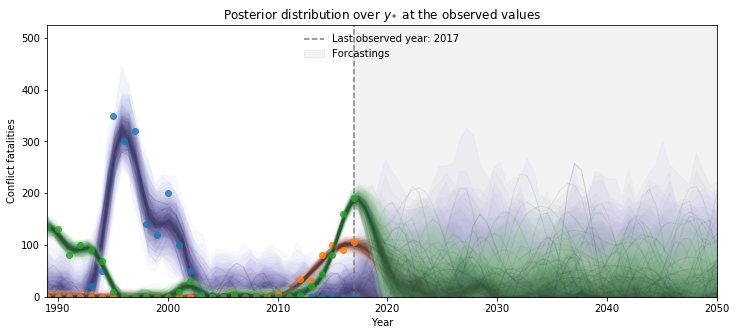

In [23]:
index_plot()

#  Hierarchical  η, and σ. Shared ℓ (for loop for scalability)

In [25]:
with pm.Model() as model:
    
    dim = len(set(index))
    
    η_β = pm.HalfNormal('η_β', 5)
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2, shape = 1)
    η = pm.HalfCauchy("η", beta=η_β, shape = dim)
    
    σ_β = pm.HalfNormal('σ_β', 5)
    σ = pm.HalfCauchy("σ", beta=σ_β, shape = dim)
    
    gp_list = []

    for i in set(index):
        cov = η[i] **2 * pm.gp.cov.ExpQuad(1, ℓ)
        gp = pm.gp.Marginal(cov_func=cov)
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X[index == i], y=y[index == i], noise=σ[i])
        
        gp_list.append(gp)
        
    # here since you do not want to find the map of the conditional distributions
    mp = pm.find_MAP()

    
    f_pred_list = []
    y_pred_list = []
    
    for i in set(index):

        f_pred = gp_list[i].conditional("f_pred" + str(i), X_new)
        f_pred_list.append(f_pred)
        
        y_pred = gp_list[i].conditional("y_pred" + str(i), X_new, pred_noise = True)
        y_pred_list.append(y_pred)
        
    
    pred_samples = pm.sample_posterior_predictive([mp], vars= f_pred_list, samples=100)
    y_samples = pm.sample_posterior_predictive([mp], vars= y_pred_list, samples=100)

        

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -457.82, ||grad|| = 0.23429: 100%|██████████| 27/27 [00:00<00:00, 89.88it/s]  
100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


In [26]:
mp

{'η': array([91.09519116, 31.29202043, 79.43703103]),
 'η_log__': array([4.51190502, 3.44336313, 4.37496465]),
 'η_β': array(8.40576339),
 'η_β_log__': array(2.12891759),
 'σ': array([49.84655257,  6.35720502, 11.62024906]),
 'σ_log__': array([3.90894934, 1.84958882, 2.45274919]),
 'σ_β': array(6.2160284),
 'σ_β_log__': array(1.82713118),
 'ℓ': array([3.40285799]),
 'ℓ_log__': array([1.22461567])}

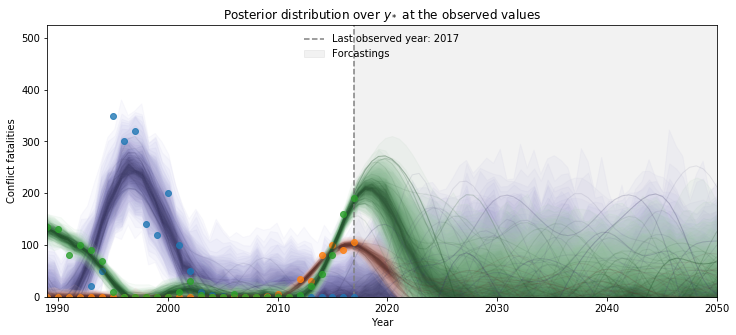

In [27]:
index_plot()

So, this works fine. Still worried about time. We will se. What about the mean function? look at the data far back to 1975?

# oldish

# cov func: RBF

In [25]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)
    
    cov0 = η[0]**2 * pm.gp.cov.ExpQuad(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.ExpQuad(1, ℓ[1])

    gp0 = pm.gp.Marginal(cov_func=cov0)
    gp1 = pm.gp.Marginal(cov_func=cov1)


    σ = pm.HalfCauchy("σ", beta=5, shape = 2)
    
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp = pm.find_MAP()
    
    # f(x)
    f_pred_0 = gp0.conditional("f_pred0", X_new)
    f_pred_1 = gp1.conditional("f_pred1", X_new)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_0 = pm.sample_posterior_predictive([mp], vars=[f_pred_0], samples=100)
    pred_samples_1 = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=100)
    
    # y = f(x) + σ
    y_pred_0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
    y_pred_1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    y_samples_0 = pm.sample_posterior_predictive([mp], vars=[y_pred_0], samples=100)
    y_samples_1 = pm.sample_posterior_predictive([mp], vars=[y_pred_1], samples=100)

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -304.18, ||grad|| = 0.38167: 100%|██████████| 16/16 [00:00<00:00, 175.61it/s]  
  0%|          | 0/100 [00:00<?, ?it/s]/home/polichinel/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:651: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 100/100 [00:02<00:00, 35.54it/s]


In [26]:
mp

{'η': array([93.68126399, 32.89287251]),
 'η_log__': array([4.53989821, 3.49325599]),
 'σ': array([35.18733623,  6.33609926]),
 'σ_log__': array([3.56068625, 1.84626332]),
 'ℓ': array([1.78693936, 3.72357512]),
 'ℓ_log__': array([0.5805043 , 1.31468426])}

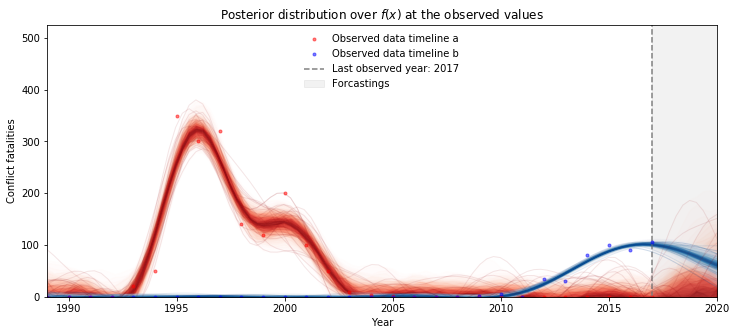

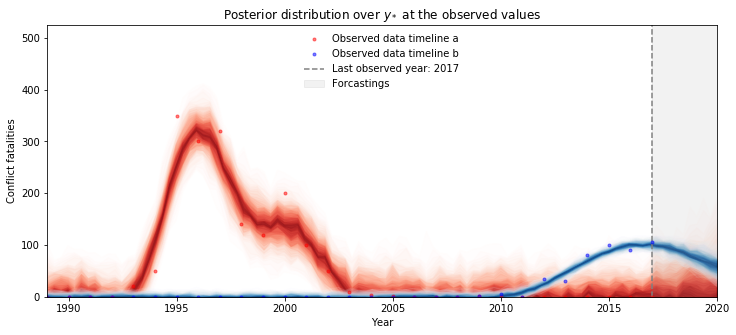

In [27]:
# f(x) -------------------------------------------------------------------------------------------------------------------

# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

fill_min = pred_years.min()
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

# y -------------------------------------------------------------------------------------------------------------------

# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, y_samples_0["y_pred0"], X_new, palette='Reds', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, y_samples_1["y_pred1"], X_new, palette='Blues', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

fill_min = pred_years.min()
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

# cov func: Matern52

In [28]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)

    cov0 = η[0]**2 * pm.gp.cov.Matern52(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.Matern52(1, ℓ[1])

    gp0 = pm.gp.Marginal(cov_func=cov0)
    gp1 = pm.gp.Marginal(cov_func=cov1)


    σ = pm.HalfCauchy("σ", beta=5, shape = 2)
    
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp = pm.find_MAP()
    
    # f(x)
    f_pred_0 = gp0.conditional("f_pred0", X_new)
    f_pred_1 = gp1.conditional("f_pred1", X_new)
    
    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_0 = pm.sample_posterior_predictive([mp], vars=[f_pred_0], samples=100)
    pred_samples_1 = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=100)
    
    # y = f(x) + σ
    y_pred_0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
    y_pred_1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    y_samples_0 = pm.sample_posterior_predictive([mp], vars=[y_pred_0], samples=100)
    y_samples_1 = pm.sample_posterior_predictive([mp], vars=[y_pred_1], samples=100)

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -306.08, ||grad|| = 1.3115: 100%|██████████| 18/18 [00:00<00:00, 171.28it/s]  
100%|██████████| 100/100 [00:04<00:00, 21.22it/s]


In [30]:
mp

{'η': array([93.18444982, 32.11922112]),
 'η_log__': array([4.53458086, 3.46945464]),
 'σ': array([33.1979856 ,  6.33841302]),
 'σ_log__': array([3.5024892 , 1.84662843]),
 'ℓ': array([2.14866796, 4.90744965]),
 'ℓ_log__': array([0.7648481 , 1.59075439])}

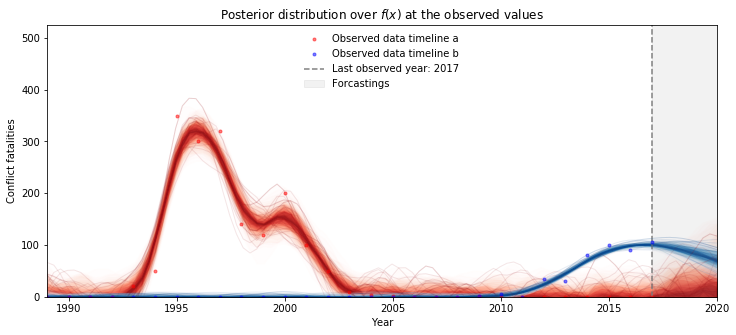

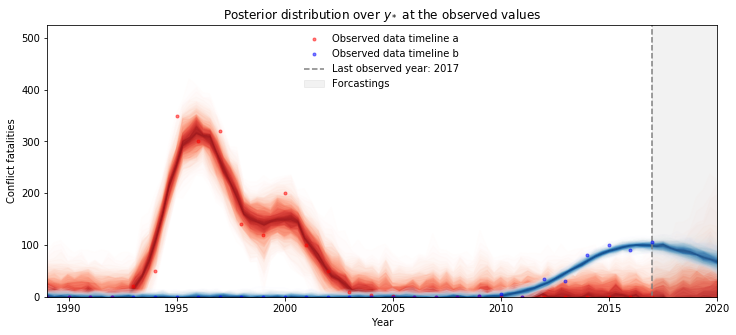

In [29]:
# f(x) -------------------------------------------------------------------------------------------------------------------

# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

fill_min = pred_years.min()
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

# y -------------------------------------------------------------------------------------------------------------------

# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, y_samples_0["y_pred0"], X_new, palette='Reds', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, y_samples_1["y_pred1"], X_new, palette='Blues', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))

fill_min = pred_years.min()
fill_max = pred_years.max() + 2
fill_range = np.arange(fill_min, fill_max, 1)

plt.fill_between(fill_range,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

### RBF seems faster, no major difference here otherwise.


# test mean func:
The reason timeline goes towrad zero up above is not least do the the prior mean function. Even if (and this I tested) the level have never reached zero in the data sample the prior will drag the functions down towards zero as we move away from the last observation. We kan do better. Onr solutions is to specifiy the mean function to a constans e.g. the median. This corrospond to the assumbtion that the fatalities count will regress towards the median in the future. Or in other words, we expected to be where it is most often been before. If you do use log(fatalities), then you can cosider using mean insted of median.

As a toy exemple we pretend that timeline b always expericence atleast 100 deaths per year. 

NOTE: your are not estimating deaths but making a trap/greavences index, Going to zero is not a bad assumbtion, and indeed if you center your target it does not matter (but then it must be logged doue to large outlayers.)


In [34]:
pred_years =  np.arange(2017, 2100, 1)

### Illusstrating the problem:

In [35]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)

    cov0 = η[0]**2 * pm.gp.cov.ExpQuad(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.ExpQuad(1, ℓ[1])
    
    # The mean function is now explicit, but this corrospond to the defualt setting used above
    mean0 = pm.gp.mean.Zero()
    mean1 = pm.gp.mean.Zero()
    
    gp0 = pm.gp.Marginal(mean_func = mean0 ,cov_func=cov0)
    gp1 = pm.gp.Marginal(mean_func = mean1 ,cov_func=cov1)

    σβ = pm.HalfNormal('σβ', 10)
    
    σ = pm.HalfCauchy("σ", beta=σβ, shape = 2)
    
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp = pm.find_MAP()
    
    
    # add the GP conditional to the model, given the new X values
    f_pred_0 = gp0.conditional("f_pred0", X_new)
    f_pred_1 = gp1.conditional("f_pred1", X_new)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_0 = pm.sample_posterior_predictive([mp], vars=[f_pred_0], samples=100)
    pred_samples_1 = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=100)
  
    # ikke relveant for pointen:
#     # add the GP conditional to the model, given the new X values
#     y_pred_0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
#     y_pred_1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


#     # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
#     y_samples_0 = pm.sample_posterior_predictive([mp], vars=[y_pred_0], samples=100)
#     y_samples_1 = pm.sample_posterior_predictive([mp], vars=[y_pred_1], samples=100)

    

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -306.58, ||grad|| = 0.00056642: 100%|██████████| 68/68 [00:00<00:00, 167.32it/s]  
  0%|          | 0/100 [00:00<?, ?it/s]/home/polichinel/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:651: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 100/100 [00:04<00:00, 23.09it/s]


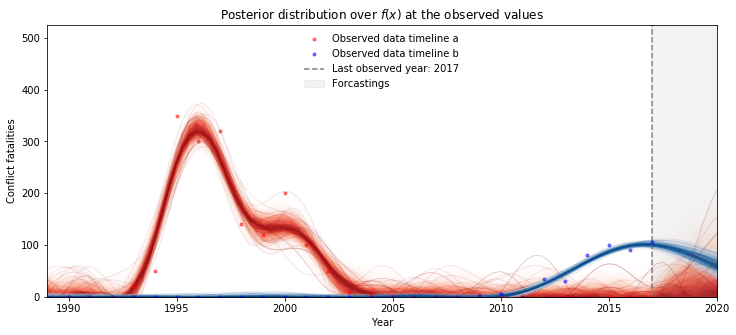

In [36]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

Thus, even though there have never been zero fatalities in timeline b, our prior drags it down - but only pretty far into the future, so it is not a major problem..

### Illustrating the solution:

In [24]:
# the model

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)

    cov0 = η[0]**2 * pm.gp.cov.ExpQuad(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.ExpQuad(1, ℓ[1])
    
    # Nice addition and reason assumbtion.
    mean0 = pm.gp.mean.Constant(np.median(y[index == 0]))
    #mean0 = pm.gp.mean.Zero()
    mean1 = pm.gp.mean.Constant(np.median(y[index == 1]))
    
    gp0 = pm.gp.Marginal(mean_func = mean0 ,cov_func=cov0)
    gp1 = pm.gp.Marginal(mean_func = mean1 ,cov_func=cov1)

    σβ = pm.HalfNormal('σβ', 10)
    
    σ = pm.HalfCauchy("σ", beta=σβ, shape = 2)
    
    # hvordan kommer de her i spli?
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp = pm.find_MAP()
    
    
    # add the GP conditional to the model, given the new X values
    f_pred_0 = gp0.conditional("f_pred0", X_new)
    f_pred_1 = gp1.conditional("f_pred1", X_new)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_0 = pm.sample_posterior_predictive([mp], vars=[f_pred_0], samples=100)
    pred_samples_1 = pm.sample_posterior_predictive([mp], vars=[f_pred_1], samples=100)
  

    # no crusial to the point:
#     # add the GP conditional to the model, given the new X values
#     y_pred_a0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
#     y_pred_a1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


#     # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
#     y_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a0], samples=100)
#     y_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a1], samples=100)

    

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -318.46, ||grad|| = 0.036: 100%|██████████| 25/25 [00:00<00:00, 113.02it/s]  
100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


In [25]:
mp_a

{'η': array([93.12770204, 31.06718799]),
 'η_log__': array([4.53397169, 3.43615221]),
 'σ': array([33.39525977, 10.17839084]),
 'σ_log__': array([3.50841397, 2.32026693]),
 'σβ': array(9.55125424),
 'σβ_log__': array(2.25667248),
 'ℓ': array([2.15426674, 3.83212174]),
 'ℓ_log__': array([0.76745041, 1.34341863])}

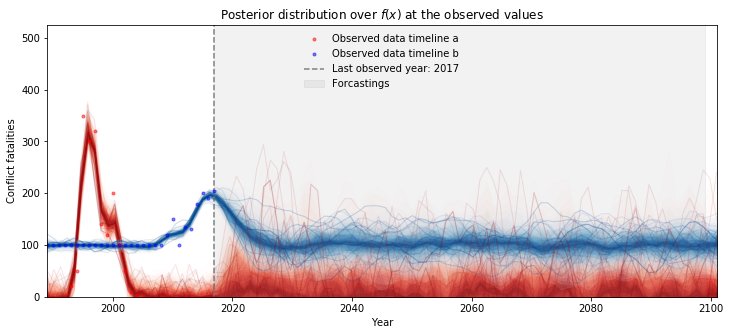

In [26]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_a0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_a1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

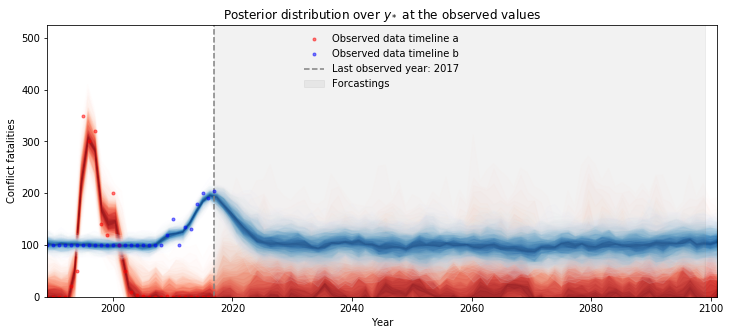

In [27]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, y_samples_a0["y_pred0"], X_new, palette='Reds', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, y_samples_a1["y_pred1"], X_new, palette='Blues', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

Sp this is an solutions... But it is also empirical bayes wich you are not a big fan of as a concept... Learning the prior from the data... Nasty buisness. But the nice thing is you could take a country mean instead of a cell mean or create some other hierarchical structure. You could use historical data.. UCDP do have data going back to 1975...

you could also just normalise or standadize the data by sub tracting the mean... But the it has to be logged.

Anyway, it is not a huge problem.. But it does need to be smarter. But that is proberly the job of the covariance function..

# What would a different cov function do?
seem RBF is faster, but results do not differ much.

In [28]:
# the model

with pm.Model() as model_a:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)

#     cov0 = η[0]**2 * pm.gp.cov.Matern52(1, ℓ[0])
#     cov1 = η[1]**2 * pm.gp.cov.Matern52(1, ℓ[1])
    
    cov0 = η[0]**2 * pm.gp.cov.ExpQuad(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.ExpQuad(1, ℓ[1])
    
    # usefull addition and reason assumbtion. But nasty to learn the prior from the data..
    mean0 = pm.gp.mean.Constant(np.median(y[index == 0]))
    mean1 = pm.gp.mean.Constant(np.median(y[index == 1]))
    
    gp0 = pm.gp.Marginal(mean_func = mean0 ,cov_func=cov0)
    gp1 = pm.gp.Marginal(mean_func = mean1 ,cov_func=cov1)

    σβ = pm.HalfNormal('σβ', 10)
    
    σ = pm.HalfCauchy("σ", beta=σβ, shape = 2)
    
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=σ[0])
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=σ[1])

    mp_a = pm.find_MAP()
    
    
    # add the GP conditional to the model, given the new X values
    f_pred_a0 = gp0.conditional("f_pred0", X_new)
    f_pred_a1 = gp1.conditional("f_pred1", X_new)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a0], samples=100)
    pred_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a1], samples=100)
    
    # add the GP conditional to the model, given the new X values
    y_pred_a0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
    y_pred_a1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    y_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a0], samples=100)
    y_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a1], samples=100)

    

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -318.54, ||grad|| = 2.8393: 100%|██████████| 28/28 [00:00<00:00, 126.73it/s]  
100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


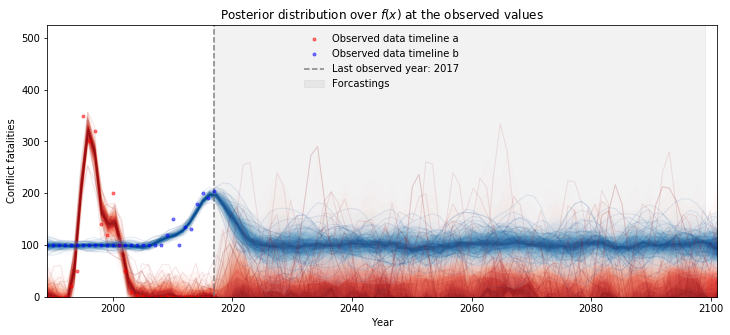

In [29]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_a0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_a1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

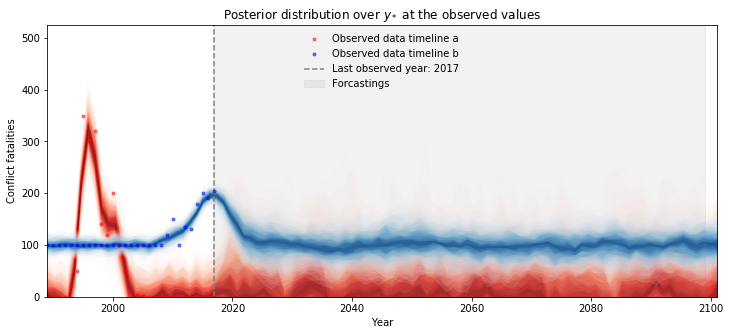

In [30]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, y_samples_a0["y_pred0"], X_new, palette='Reds', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, y_samples_a1["y_pred1"], X_new, palette='Blues', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

# With noise cov function:

In [31]:
# the model

with pm.Model() as model_a:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1, shape = 2)
    η = pm.HalfCauchy("η", beta=5, shape = 2)
    
    cov0 = η[0]**2 * pm.gp.cov.ExpQuad(1, ℓ[0])
    cov1 = η[1]**2 * pm.gp.cov.ExpQuad(1, ℓ[1])
    
    # usefull addition and reason assumbtion. But nasty to learn the prior from the data..
    mean0 = pm.gp.mean.Constant(np.median(y[index == 0]))
    mean1 = pm.gp.mean.Constant(np.median(y[index == 1]))
    
    gp0 = pm.gp.Marginal(mean_func = mean0 ,cov_func=cov0)
    gp1 = pm.gp.Marginal(mean_func = mean1 ,cov_func=cov1)

    σβ = pm.HalfNormal('σβ', 10)
    
    # noise model
    η_noise = pm.HalfNormal("η_noise", sd=0.5, testval=0.05, shape = 2)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4, shape = 2)
    
    σ  = pm.HalfNormal("σ",  sd=10)
    
    cov_noise0 = η_noise[0]**2 * pm.gp.cov.Matern32(1, ℓ_noise[0]) + pm.gp.cov.WhiteNoise(σ)
    cov_noise1 = η_noise[1]**2 * pm.gp.cov.Matern32(1, ℓ_noise[1]) + pm.gp.cov.WhiteNoise(σ)

    #cov_noise0 = pm.gp.cov.WhiteNoise(σ[0])
    #cov_noise1 = pm.gp.cov.WhiteNoise(σ[1])

        
    y1_0 = gp0.marginal_likelihood("y1", X=X, y=y1, noise=cov_noise0)
    y2_1 = gp1.marginal_likelihood("y2", X=X, y=y2, noise=cov_noise1)

    mp_a = pm.find_MAP()
    
    
    # add the GP conditional to the model, given the new X values
    f_pred_a0 = gp0.conditional("f_pred0", X_new)
    f_pred_a1 = gp1.conditional("f_pred1", X_new)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    pred_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a0], samples=100)
    pred_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[f_pred_a1], samples=100)
    
    # add the GP conditional to the model, given the new X values
    y_pred_a0 = gp0.conditional("y_pred0", X_new, pred_noise = True)
    y_pred_a1 = gp1.conditional("y_pred1", X_new, pred_noise = True)


    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    y_samples_a0 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a0], samples=100)
    y_samples_a1 = pm.sample_posterior_predictive([mp_a], vars=[y_pred_a1], samples=100)

    

/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -323.25, ||grad|| = 0.013442: 100%|██████████| 69/69 [00:00<00:00, 101.90it/s] 
100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


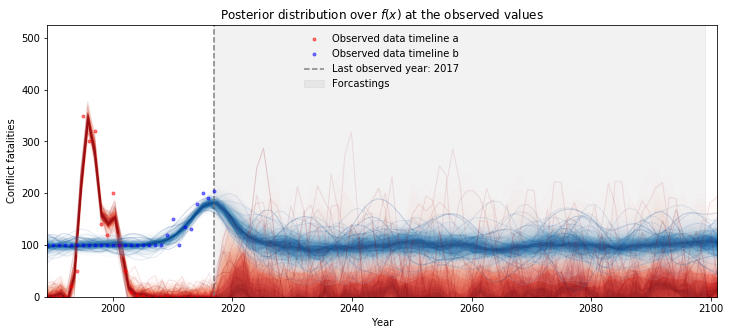

In [32]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples_a0["f_pred0"], X_new, palette='Reds', fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, pred_samples_a1["f_pred1"], X_new, palette='Blues', fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

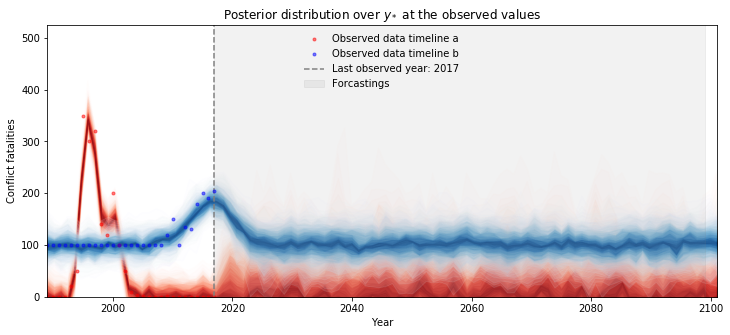

In [33]:
# plot the results
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, y_samples_a0["y_pred0"], X_new, palette='Reds', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)
plot_gp_dist(ax, y_samples_a1["y_pred1"], X_new, palette='Blues', plot_samples=False, fill_alpha=0.1, samples_alpha=0.1)

# plot the data and the
plt.plot(X, y[index==0], 'ro', ms=3, alpha=0.5, label="Observed data timeline a")
plt.plot(X, y[index==1], 'bo', ms=3, alpha=0.5, label="Observed data timeline b")

# prediction line
plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))
plt.fill_between(pred_yeas,y.min(),y.max()*2, color = 'gray', alpha = 0.1, label = 'Forcastings')

# axis labels and title
plt.xlabel("Year")
plt.ylabel('Conflict fatalities')
plt.title("Posterior distribution over $y_*$ at the observed values"); plt.legend()

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)
#sns.despine()

plt.savefig('GP_forcasting_test.png', bbox_inches='tight')


plt.show()

Det ligner i hvertfald de har lært noget af hinanden...
umiddelbart mindre var på a og mere på b.

# Students T

https://docs.pymc.io/notebooks/GP-TProcess.html

In [56]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2)
    η = pm.HalfCauchy("η", beta=3)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

    # informative prior on degrees of freedom < 5
    ν = pm.Gamma("ν", alpha=2, beta=1)
    tp = pm.gp.TP(cov_func=cov, nu=ν)
    f = tp.prior("f", X=X)

    # adding a small constant seems to help with numerical stability here
    y_ = pm.Poisson("y", mu=tt.square(f) + 1e-6, observed=y[index == 1])

    tr = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, chi2_, ν, η, ℓ]
Sampling 4 chains: 100%|██████████| 2400/2400 [11:30<00:00,  1.94draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


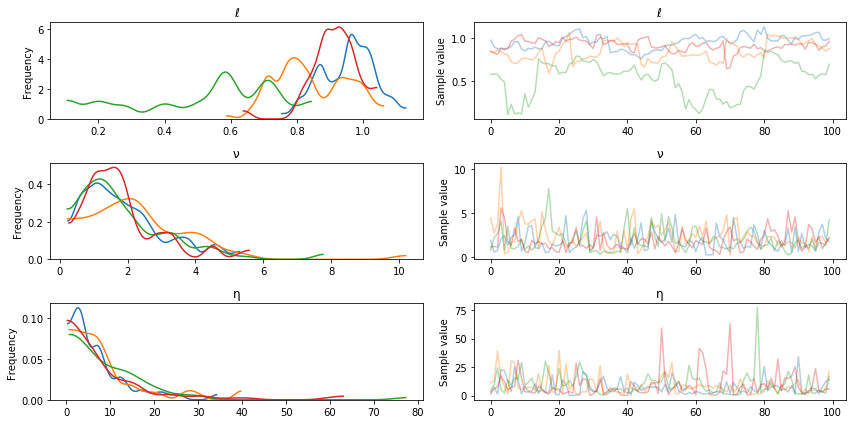

In [58]:
pm.traceplot(tr, varnames=["ℓ", "ν", "η"])
plt.show()



In [57]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(tr, vars=[f_pred], samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock
/home/polichinel/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:651: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]


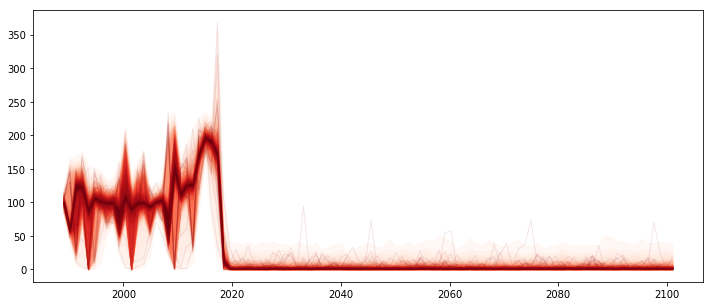

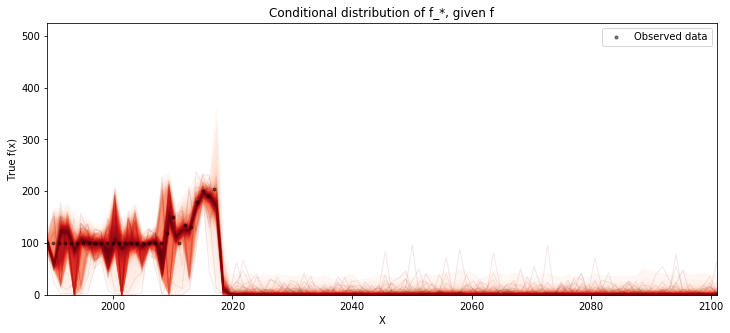

In [60]:


fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, np.square(pred_samples["f_pred"]), X_new)

plt.plot(X, y[index == 1], 'ok', ms=3, alpha=0.5, label="Observed data")

plt.xlabel("X")
plt.ylabel("True f(x)") 

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)

plt.title("Conditional distribution of f_*, given f"); plt.legend();

plt.show()

# change point

In [63]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return pm.math.invlogit(a*(x - x0))

In [72]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.1)
    
    # ******************************************************************
    # changepoint occurs near the year 1800, sometime between 1760, 1840
    x0 = pm.Normal("x0", mu=0, sd=10)
    # the change happens gradually
    a = pm.HalfNormal("a", sd=2)
    # a constant for the
    c = pm.HalfNormal("c", sd=3)
    # quadratic polynomial scale
    ηq = pm.HalfNormal("ηq", sd=5)
    # *******************************************************************

    cov1 = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    cov2 = η**2 * pm.gp.cov.ExpQuad(1, ℓ) + ηq**2 * pm.gp.cov.Polynomial(1, x0, 2, c)

    # construct changepoint cov
    sc_cov1 = pm.gp.cov.ScaledCov(1, cov1, logistic, (-a, x0))
    sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, logistic, ( a, x0))
    cov_c = sc_cov1 + sc_cov2

    # short term variation
    ηs = pm.HalfNormal("ηs", sd=5)
    ℓs = pm.Gamma("ℓs", alpha=2, beta=1)
    cov_s = ηs**2 * pm.gp.cov.Matern52(1, ℓs)

    gp = pm.gp.Marginal(cov_func=cov_s + cov_c)

    #t_diff = pm.Normal("t_diff", mu=0.0, sd=0.02, shape=X.shape[0])
    #t_uncert = t_n - t_diff

    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y[index == 1], noise=σ)

INFO (theano.gof.compilelock): Refreshing lock /home/polichinel/.theano/compiledir_Linux-4.10--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir/lock


In [73]:
with model:
    tr = pm.sample(500, tune=1000, chains=8, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [σ, ℓs, ηs, ηq, c, a, x0, ℓ, η]
Sampling 8 chains:   1%|          | 115/12000 [00:06<16:09, 12.26draws/s]/home/polichinel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
Series([], )


ParallelSamplingError: Bad initial energy

In [ ]:
pm.traceplot(tr)
plt.show()

In [ ]:
with model:
    f_pred = gp.conditional("fnew", X_new)

In [ ]:
with model:
    pred_samples = pm.sample_posterior_predictive(tr, samples=200, vars=[fnew])
    

In [ ]:


fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, np.square(pred_samples["f_pred"]), X_new)

plt.plot(X, y[index == 1], 'ok', ms=3, alpha=0.5, label="Observed data")

plt.xlabel("X")
plt.ylabel("True f(x)") 

plt.ylim(0,y.max()*1.5)
plt.xlim(X_new.min(), X_new.max())
plt.legend(frameon = False, loc = 9)

plt.title("Conditional distribution of f_*, given f"); plt.legend();

plt.show()

# next step spatial auto corrolation!